In [29]:
import numpy as np
import pandas as pd
import os

In [30]:
import torch
torch.set_float32_matmul_precision('medium')  # or 'high'
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class MapsTransform:
    def __init__(self, mirror_prob: float = 0):
        self.mirror_prob = mirror_prob
        
    def __jitter(self, x, y):
        torch.manual_seed(42)
        random_crop = T.RandomCrop((256, 256))
        x, y = random_crop(x), random_crop(y)
        torch.manual_seed(0)
        return x, y
        
                
    def __call__(self, x, y):
        
        # resizing
        x, y = TF.resize(x, [286, 286]), TF.resize(y, [286, 286])
        
        # random jittering
        x, y = self.__jitter(x, y)
        
        # horizontal flip
        r = np.random.uniform()
        if r <= self.mirror_prob:
            x, y = TF.hflip(x), TF.hflip(y)
        
        return {
            "areal": x,
            "map_pic": y
        }

In [31]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class MapsDataset(Dataset):
    def __init__(self, img_folder: str, transform = None):
        self.img_folder = img_folder
        self.imgs = os.listdir(img_folder)
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img = os.path.join(self.img_folder, img_name)
        img = Image.open(img)
        img = TF.to_tensor(img)
        width = img.shape[2] // 2
        areal, map_pic = img[:, :, :width], img[:, :, width:]
        if self.transform != None:
            transformed = self.transform(areal, map_pic)
            areal, map_pic = transformed["areal"], transformed["map_pic"]
        areal = TF.normalize(areal, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        map_pic = TF.normalize(map_pic, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return {
            "areal": areal,
            "map_pic": map_pic
        }

In [32]:
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=1):
        super().__init__()
        self.batch_size=batch_size
        
    def setup(self, stage=None):
        transform = MapsTransform(0.5)
        self.train_dataset = MapsDataset("mapas/train", transform)
        self.validation_dataset = MapsDataset("mapas/val", transform)
        
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.validation_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        return val_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


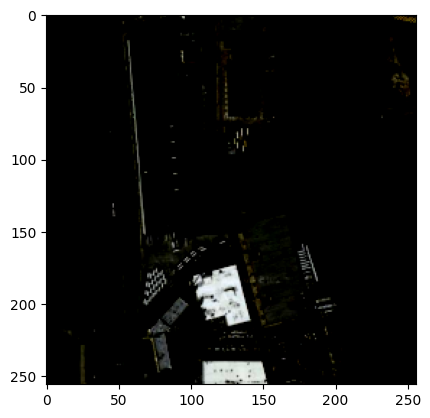

In [33]:
ds = MapsDataset("mapas/train", MapsTransform(1))
a = ds[101]
areal, map_pic = a["areal"], a["map_pic"]
areal = areal.numpy()
areal = np.moveaxis(areal, 0, 2)
import matplotlib.pyplot as plt

plt.imshow(areal)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


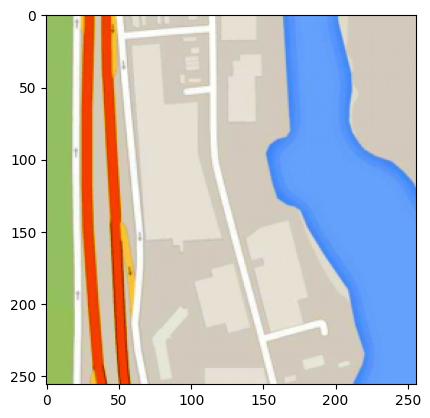

In [34]:
map_pic = map_pic.numpy()
map_pic = np.moveaxis(map_pic, 0, 2)
plt.imshow(map_pic)

In [35]:
np.min(map_pic)

-0.805783

In [36]:
class DownBlock(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_filters: int,
        use_norm: bool = True,
        last_layer: bool = False
    ):
        super().__init__()
        stride = 1 if last_layer else 2
        self.conv = nn.Conv2d(num_channels, num_filters, 4, stride, 1)
        self.norm = nn.InstanceNorm2d(num_filters, affine=True) if use_norm else nn.Identity()
        self.leaky = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return self.leaky(x)
    
class UpBlock(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_filters: int,
        use_dropout: bool = False
    ):
        super().__init__()
        self.conv = nn.ConvTranspose2d(num_channels, num_filters, 4, 2, 1)
        self.relu = nn.ReLU()
        self.norm = nn.InstanceNorm2d(num_filters, affine=True)
        self.drop = nn.Dropout(0.5) if use_dropout else nn.Identity()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.drop(x)
        return self.relu(x)
        
        


In [37]:
class Discriminator(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.down1 = DownBlock(input_channels * 2, 64, use_norm=False)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512, last_layer=True)
        self.final = nn.Conv2d(512, 1, kernel_size=4, padding=1)
    
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        
        return self.final(x)
                

class Generator(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.input_channels = input_channels
        self.down1 = DownBlock(input_channels, 64, use_norm=False)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)
        self.down5 = DownBlock(512, 512)
        self.down6 = DownBlock(512, 512)
        self.down7 = DownBlock(512, 512)
        
        self.bottleneck = DownBlock(512, 512, last_layer=True, use_norm=False)
        
        self.up1 = UpBlock(512, 512, True)
        self.up2 = UpBlock(1024, 512, True)
        self.up3 = UpBlock(1024, 512, True)
        self.up4 = UpBlock(1024, 512)
        self.up5 = UpBlock(1024, 256)
        self.up6 = UpBlock(512, 128)
        self.up7 = UpBlock(256, 64)
        self.up8 = nn.ConvTranspose2d(128, input_channels, 4, 2, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        btn = self.bottleneck(d7)
        
        up1 = self.up1(btn)
        up2 = self.up2(torch.concat([up1, d7], dim=1))
        up3 = self.up3(torch.concat([up2, d6], dim=1))
        up4 = self.up4(torch.concat([up3, d5], dim=1))
        up5 = self.up5(torch.concat([up4, d4], dim=1))
        up6 = self.up6(torch.concat([up5, d3], dim=1))
        up7 = self.up7(torch.concat([up6, d2], dim=1))
        up8 = self.up8(torch.concat([up7, d1], dim=1))
        return self.tanh(up8)

In [38]:
def init_weights(m):
    if isinstance(m, DownBlock):
        nn.init.normal_(m.conv.weight, 0.0, 0.02)
        if isinstance(m.norm, nn.InstanceNorm2d):
            nn.init.normal_(m.norm.weight, 0.0, 0.02)
            
    elif isinstance(m, UpBlock):
        nn.init.normal_(m.conv.weight, 0.0, 0.02)
        nn.init.normal_(m.norm.weight, 0.0, 0.02)
        
    elif isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        
        
def display_results(x, y, y_hat, current_epoch: int, path: str,figsize=(10,5)):
    x = x.detach().cpu().permute(1, 2, 0)
    y = y.detach().cpu().permute(1, 2, 0)
    y_hat = y_hat.detach().cpu().permute(1, 2, 0)
    
    x, y, y_hat = x.float(), y.float(), y_hat.float()
    
    images = [x, y, y_hat]
    titles = ['input','real','generated']
    print(f'Epoch: {current_epoch}')
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for idx,img in enumerate(images):
        ax[idx].imshow(img)
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
    plt.savefig(path)
    plt.show()

In [39]:
m = Generator()
m.apply(init_weights)
a = m(torch.rand(1, 3, 256, 256))
a.shape

torch.Size([1, 3, 256, 256])

In [40]:
m = Discriminator()
m.apply(init_weights)
a = m(torch.rand(1, 3, 256, 256), torch.rand(1, 3, 256, 256))
a.shape

torch.Size([1, 1, 30, 30])

In [49]:
class Pix2Pix(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.discriminator = Discriminator(3)
        self.generator = Generator(3)
        self.generator.apply(init_weights)
        self.discriminator.apply(init_weights)
        self.bce = nn.BCEWithLogitsLoss()
        self.l1 = nn.L1Loss()

        # Set automatic optimization to False
        self.automatic_optimization = False

    def forward(self, x):
        return self.generator(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch["areal"], batch["map_pic"]
        
        # Get optimizers
        opt_d, opt_g = self.optimizers()
        
        # Train Discriminator
        opt_d.zero_grad()
        y_fake = self(x)
        D_real = self.discriminator(x, y)
        D_fake = self.discriminator(x, y_fake.detach())
        D_real_loss = self.bce(D_real, torch.ones_like(D_real))
        D_fake_loss = self.bce(D_fake, torch.zeros_like(D_fake))
        loss_d = (D_real_loss + D_fake_loss) / 2
        self.manual_backward(loss_d)
        opt_d.step()
        self.log('Discriminator loss', loss_d, prog_bar=True)

        # Train Generator
        opt_g.zero_grad()
        y_fake = self(x)
        D_fake = self.discriminator(x, y_fake)
        loss_g = self.bce(D_fake, torch.ones_like(D_fake))
        l1_loss = self.l1(y_fake, y) * 200
        loss_g += l1_loss
        self.manual_backward(loss_g)
        opt_g.step()
        self.log('Generator loss', loss_g, prog_bar=True)
        
        # Optionally save results periodically
        if batch_idx == 0:
            y_hat = self(x).detach()
            display_results(
                x[0],
                y[0],
                y_hat[0],
                self.current_epoch,
                "results/{}".format(self.current_epoch)
            )
    
    def configure_optimizers(self):
        generator_opt = torch.optim.Adam(self.generator.parameters(),  0.0002, betas=(0.5, 0.999))
        discriminator_opt = torch.optim.Adam(self.discriminator.parameters(),  0.0002, betas=(0.5, 0.999))
        return [discriminator_opt, generator_opt]
        

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | discriminator | Discriminator     | 2.8 M 
1 | generator     | Generator         | 54.4 M
2 | bce           | BCEWithLogitsLoss | 0     
3 | l1            | L1Loss            | 0     
----------------------------------------------------
57.2 M    Trainable params
0         Non-trainable params
57.2 M    Total params
228.756   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0


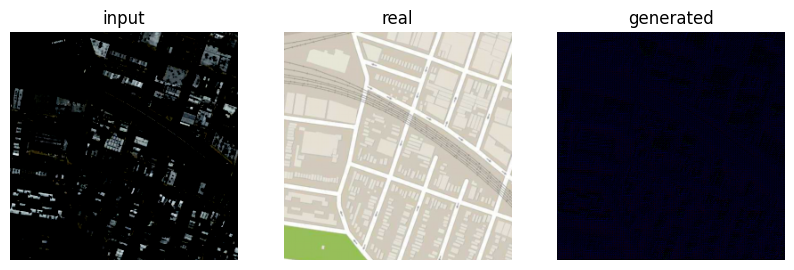

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1


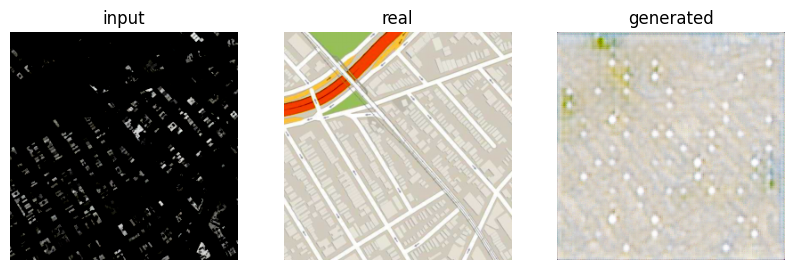

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2


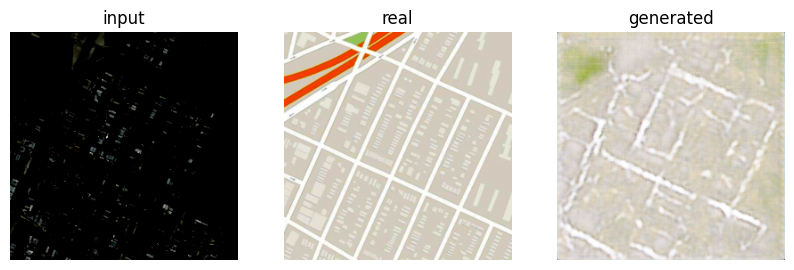

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3


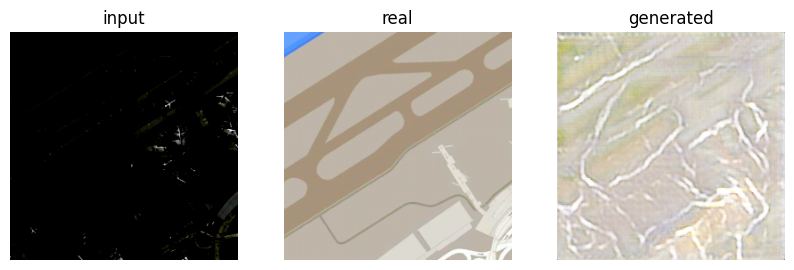

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4


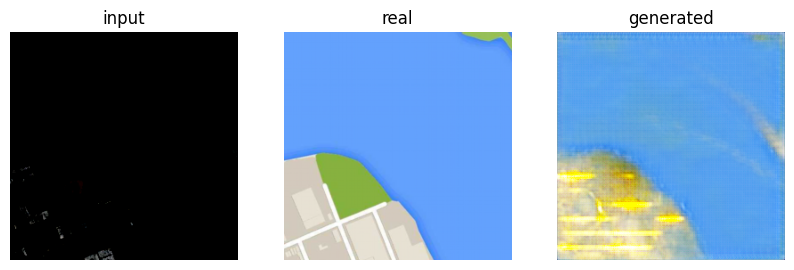

`Trainer.fit` stopped: `max_epochs=5` reached.


In [50]:
transform = MapsTransform(0.5)
dataset = MapsDataset("mapas/train", transform)
train_dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2
)
model = Pix2Pix()

trainer = pl.Trainer(
    accelerator="auto",
    precision=16,
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=5,
    callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)],
    default_root_dir="./",
)

trainer.fit(
    model=model,
    train_dataloaders=train_dataloader
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | discriminator | Discriminator     | 2.8 M 
1 | generator     | Generator         | 54.4 M
2 | bce           | BCEWithLogitsLoss | 0     
3 | l1            | L1Loss            | 0     
----------------------------------------------------
57.2 M    Trainable params
0         Non-trainable params
57.2 M    Total params
228.756   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0


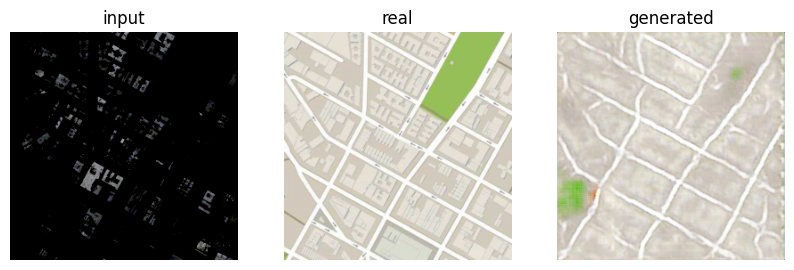

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1


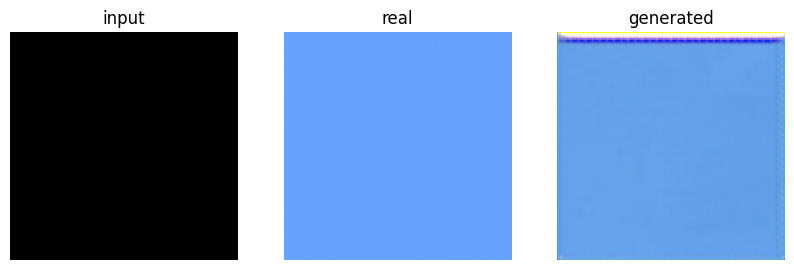

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2


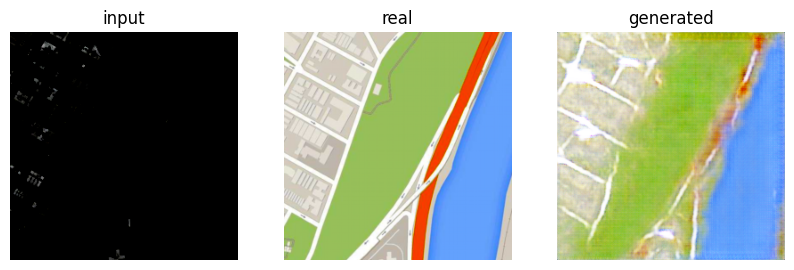

In [53]:
trainer = pl.Trainer(
    accelerator="auto",
    precision=16,
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=5,
    callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)],
    default_root_dir="./",
)

trainer.fit(
    model=model,
    train_dataloaders=train_dataloader
)